In [1]:
# https://colab.research.google.com/github/vsitzmann/siren/blob/master/explore_siren.ipynb

In [2]:
!pip install -U scikit-image
!pip install -U miplib

Requirement already up-to-date: scikit-image in ./miniconda3/envs/thesis/lib/python3.7/site-packages (0.18.1)
Requirement already up-to-date: miplib in ./miniconda3/envs/thesis/lib/python3.7/site-packages (1.0.6)


In [3]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize, ToPILImage
import numpy as np
import skimage
import matplotlib.pyplot as plt

import time

def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

!pip install gemmi
import gemmi

In [4]:
# https://github.com/sakoho81/miplib
# Install: https://pypi.org/project/miplib/

import miplib.analysis.resolution.fourier_ring_correlation as frc
from miplib.data.containers.fourier_correlation_data import FourierCorrelationDataCollection
import miplib.ui.plots.frc as frcplots
from miplib.ui.cli import miplib_entry_point_options as options
from miplib.data.containers.image import Image
import miplib.data.io.read as imread

In [5]:
from inspect import getmembers, isfunction
getmembers(frc, isfunction)

[('batch_evaluate_frc',
  <function miplib.analysis.resolution.fourier_ring_correlation.batch_evaluate_frc>),
 ('calculate_single_image_frc',
  <function miplib.analysis.resolution.fourier_ring_correlation.calculate_single_image_frc>),
 ('calculate_single_image_sectioned_frc',
  <function miplib.analysis.resolution.fourier_ring_correlation.calculate_single_image_sectioned_frc>),
 ('calculate_two_image_frc',
  <function miplib.analysis.resolution.fourier_ring_correlation.calculate_two_image_frc>)]

In [6]:
getmembers(imread, isfunction)

[('__bioformats', <function miplib.data.io.read.__bioformats>),
 ('__itk_image', <function miplib.data.io.read.__itk_image>),
 ('__itk_transform', <function miplib.data.io.read.__itk_transform>),
 ('__tiff', <function miplib.data.io.read.__tiff>),
 ('get_image', <function miplib.data.io.read.get_image>)]

In [7]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords        

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
                    
                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else: 
                x = layer(x)
                
                if retain_grad:
                    x.retain_grad()
                    
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

In [8]:
def laplace(y, x):
    grad = gradient(y, x)
    return divergence(grad, x)


def divergence(y, x):
    div = 0.
    for i in range(y.shape[-1]):
        div += torch.autograd.grad(y[..., i], x, torch.ones_like(y[..., i]), create_graph=True)[0][..., i:i+1]
    return div


def gradient(y, x, grad_outputs=None):
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
    grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
    return grad

In [21]:
# Getting test T20S map
if not (os.path.exists('emd_6287.map.gz') or os.path.exists('emd_6287.map')):
    !wget ftp://ftp.ebi.ac.uk/pub/databases/emdb/structures/EMD-6287/map/emd_6287.map.gz
    !gunzip 'emd_6287.map.gz'
map_path = 'emd_6287.map'

# https://bioinformatics.stackexchange.com/questions/13079/ccp4-file-to-a-python-3-numpy-array-or-similar-workaround
test_map = gemmi.read_ccp4_map(map_path)
test_map.setup()  # optional


test_numpy = np.array(test_map.grid, copy=False)
test_slice = test_numpy[:, :, test_numpy.shape[2] // 2]
img = np.expand_dims(test_slice, axis=-1)

print(np.unique(img))
print(img.shape)
print(img.dtype)

'''
# test_numpy = np.array(test_map.grid, copy=False)
test_numpy = (test_numpy - np.amin(test_numpy)) / (np.amax(test_numpy) - np.amin(test_numpy))
test_slice = test_numpy[:, :, test_numpy.shape[2] // 2]
test_slice = np.expand_dims(test_slice, axis=-1)

plt.imshow(test_slice, cmap='gray', vmin=0, vmax=1)

c = [test_slice.shape[0]//2, test_slice.shape[1]//2]
r = 256 // 2
img = test_slice[c[0]-r:c[0]+r, c[1]-r:c[1]+r]
'''

[-0.10922459 -0.1092237  -0.1080783  ...  0.12739964  0.1313576
  0.13135967]
(300, 300, 1)
float32


"\n# test_numpy = np.array(test_map.grid, copy=False)\ntest_numpy = (test_numpy - np.amin(test_numpy)) / (np.amax(test_numpy) - np.amin(test_numpy))\ntest_slice = test_numpy[:, :, test_numpy.shape[2] // 2]\ntest_slice = np.expand_dims(test_slice, axis=-1)\n\nplt.imshow(test_slice, cmap='gray', vmin=0, vmax=1)\n\nc = [test_slice.shape[0]//2, test_slice.shape[1]//2]\nr = 256 // 2\nimg = test_slice[c[0]-r:c[0]+r, c[1]-r:c[1]+r]\n"

In [22]:
output_dims = 256

In [23]:
def convert_to_tensor(img, sidelength):
    transform = Compose([
        ToPILImage(),
        Resize(sidelength),
        ToTensor(),
        # Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
    ])
    img = transform(img)
    return img

class ImageFitting(Dataset):
    def __init__(self, img, sidelength):
        super().__init__()
        img = convert_to_tensor(img, sidelength)
        self.pixels = img.permute(1, 2, 0).view(-1, 1)
        self.coords = get_mgrid(sidelength, 2)

    def __len__(self):
        return 1

    def __getitem__(self, idx):    
        if idx > 0: raise IndexError
            
        return self.coords, self.pixels

particle_slice = ImageFitting(img, output_dims)
dataloader = DataLoader(particle_slice, batch_size=1, pin_memory=True, num_workers=0)

siren_model = Siren(in_features=2, out_features=1, hidden_features=128, 
                  hidden_layers=3, outermost_linear=True)
siren_model.cuda()

Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=2, out_features=128, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=128, out_features=128, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=128, out_features=128, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=128, out_features=128, bias=True)
    )
    (4): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [24]:
# Initially trained on 256 output dims

In [25]:
total_steps = 2500 # Since the whole image is our dataset, this just means 500 gradient descent steps.
steps_til_summary = 10

optim = torch.optim.Adam(lr=1e-4, params=siren_model.parameters())

model_input, ground_truth = next(iter(dataloader))
model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

for step in range(total_steps):
    model_output, coords = siren_model(model_input)    
    loss = ((model_output - ground_truth)**2).mean()
    
    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f" % (step, loss))
        # img_grad = gradient(model_output, coords)
        # img_laplacian = laplace(model_output, coords)

        '''
        fig, axes = plt.subplots(1,1, figsize=(18,6))
        axes.imshow(model_output.cpu().view(output_dims,output_dims).detach().numpy())
        # axes[1].imshow(img_grad.norm(dim=-1).cpu().view(256,256).detach().numpy())
        # axes[2].imshow(img_laplacian.cpu().view(256,256).detach().numpy())
        plt.show()
        '''

    optim.zero_grad()
    loss.backward()
    optim.step()

Step 0, Total loss 0.002761
Step 10, Total loss 0.000369
Step 20, Total loss 0.000138
Step 30, Total loss 0.000077
Step 40, Total loss 0.000074
Step 50, Total loss 0.000063
Step 60, Total loss 0.000061
Step 70, Total loss 0.000060
Step 80, Total loss 0.000059
Step 90, Total loss 0.000058
Step 100, Total loss 0.000057
Step 110, Total loss 0.000057
Step 120, Total loss 0.000057
Step 130, Total loss 0.000056
Step 140, Total loss 0.000056
Step 150, Total loss 0.000056
Step 160, Total loss 0.000056
Step 170, Total loss 0.000055
Step 180, Total loss 0.000055
Step 190, Total loss 0.000055
Step 200, Total loss 0.000055
Step 210, Total loss 0.000055
Step 220, Total loss 0.000054
Step 230, Total loss 0.000054
Step 240, Total loss 0.000054
Step 250, Total loss 0.000054
Step 260, Total loss 0.000054
Step 270, Total loss 0.000054
Step 280, Total loss 0.000054
Step 290, Total loss 0.000053
Step 300, Total loss 0.000053
Step 310, Total loss 0.000053
Step 320, Total loss 0.000053
Step 330, Total loss 

In [26]:
final_siren_output = model_output.cpu().view(output_dims, output_dims).detach().numpy()

In [27]:
print(final_siren_output.shape) # Should be (256, 256)

(256, 256)


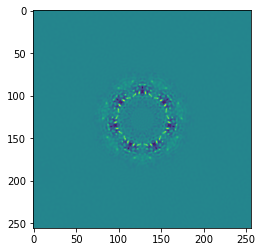

In [28]:
plt.imshow(final_siren_output)

In [29]:
# Preparing new data with 512 output
output_dims = 512

particle_slice = ImageFitting(img, output_dims)
dataloader = DataLoader(particle_slice, batch_size=1, pin_memory=True, num_workers=0)
model_input, ground_truth = next(iter(dataloader))
model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

In [30]:
model_output, coords = siren_model(model_input)
final_siren_output = model_output.cpu().view(output_dims, output_dims).detach().numpy()

In [31]:
print(final_siren_output.shape) # Should be (512, 512)

(512, 512)


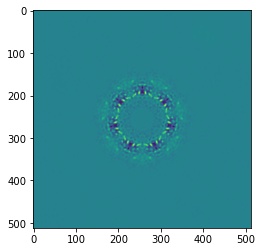

In [32]:
plt.imshow(final_siren_output)

In [17]:
# https://github.com/sakoho81/miplib/blob/10f14c8eccefcc0d90feea8dcea5b36a3801797b/miplib/processing/ndarray.py#L180
# From above

def safe_divide(numerator, denominator):
    with np.errstate(divide="ignore", invalid="ignore"):
        result = numerator / denominator
        result[result == np.inf] = 0.0
        return np.nan_to_num(result)
    
# https://github.com/sakoho81/miplib/blob/10f14c8eccefcc0d90feea8dcea5b36a3801797b/miplib/ui/plots/frc.py#L388
# Slightly altered from code above to fix labels and similar

def __make_frc_subplot(ax, frc, title):
    """
    Creates a plot of the FRC curves in the curve_list. Single or multiple vurves can
    be plotted.
    """

    # # Font setting
    # font0 = FontProperties()
    # font1 = font0.copy()
    # font1.set_size('medium')
    # font = font1.copy()
    # font.set_family('sans')
    # rc('text', usetex=True)

    # Enable grid
    gridLineWidth = 0.2
    # ax.yaxis.grid(True, linewidth=gridLineWidth, linestyle='-', color='0.05')

    # Axis labelling
    xlabel = 'Frequency (1/px)'
    ylabel = 'Correlation'
    # ax.set_xlabel(xlabel, fontsize=12, position=(0.5, -0.2))
    # ax.set_ylabel(ylabel, fontsize=12, position=(0.5, 0.5))
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    ax.set_ylim([0, 1.2])

    # Title
    ax.set_title(title)

    # Plot calculated FRC values as xy scatter.
    y = frc.correlation["correlation"]
    x = frc.correlation["frequency"]
    x_axis = safe_divide(x, 2 * frc.resolution["spacing"])

    ax.plot(x_axis, y, '^', markersize=6, color='#b5b5b3',
            label='FRC')

    # Plot polynomial fit as a line plot over the FRC scatter
    y = frc.correlation["curve-fit"]
    ax.plot(x_axis, y, linewidth=3, color='#61a2da',
            label='Least-squares fit')

    # Plot the resolution threshold curve
    y = frc.resolution["threshold"]
    res_crit = frc.resolution["criterion"]
    if res_crit == 'one-bit':
        label = 'One-bit curve'
    elif res_crit == 'half-bit':
        label = 'Half-bit curve'
    elif res_crit == 'fixed':
        label = 'y = %f' % y[0]
    else:
        label = "Threshold"

    if x[-1] < 1.0:
        x = np.append(x, 1.0)
        y = np.append(y, y[-1])

    x_axis = safe_divide(x, 2 * frc.resolution["spacing"])

    ax.plot(x_axis, y, color='#d77186',
            label=label, lw=2, linestyle='--')

    # Plot resolution point
    y0 = frc.resolution["resolution-point"][0]
    x0 = frc.resolution["resolution-point"][1] / (2 * frc.resolution["spacing"])

    ax.plot(x0, y0, 'ro', markersize=8, label='Resolution point', color='#D75725')

    verts = [(x0, 0), (x0, y0)]
    xs, ys = list(zip(*verts))

    ax.plot(xs, ys, 'x--', lw=3, color='#D75725', ms=10)
    # ax.text(x0, y0 + 0.10, 'RESOL-FREQ', fontsize=12)

    resolution = "The resolution is {} px.".format(
        frc.resolution["resolution"])
    ax.text(0.5, -0.3, resolution, ha="center", fontsize=12)

In [18]:
args_list = ("None \
--bin-delta=1 \
--frc-curve-fit-type=smooth-spline \
--resolution-threshold-criterion=fixed \
--frc-mode=two-image \
--resolution-threshold-value=0.5 \
--resolution-snr-value=1").split()
            
args = options.get_frc_script_options(args_list)

frc_results = FourierCorrelationDataCollection()

original_image = img
pred_image = final_siren_output

# Voxels for T20S is 0.98
# Spacing might indicate scale of pixels to um...
# spacing = 0.98
spacing = 1
frc_results[0] = frc.calculate_two_image_frc(Image(images=original_image.squeeze(), spacing=[spacing, spacing]), Image(images=pred_image.squeeze(), spacing=[spacing, spacing]), args)

# Plotting
plotter = frcplots.FourierDataPlotter(frc_results)
angle = 0
# plotter.plot_one(angle=angle)

plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

__make_frc_subplot(ax, plotter.data[int(angle)], "FRC at angle %s" % str(angle))

plt.show()

# Use this code to change the label 
# https://github.com/sakoho81/miplib/blob/10f14c8eccefcc0d90feea8dcea5b36a3801797b/miplib/ui/plots/frc.py

AssertionError: 

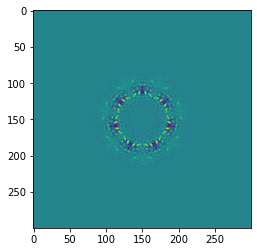

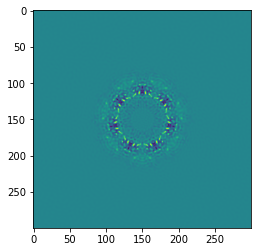

In [75]:
plt.imshow(original_image)
plt.show()
plt.imshow(pred_image)
plt.show()